In [371]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={}

import io
import math
import os
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from IPython.display import Markdown, display, Image
from PIL import Image as PILImage

# LOCAL GIT REPOSITORY LOCATION FOR https://github.com/CSSEGISandData/COVID-19
local_covid_19_data = '/Users/davidmorton/Documents/COVID-19/'

!git -C $local_covid_19_data pull

states_to_drop = ['Puerto Rico', 'American Samoa', 'Guam', 'District of Columbia', 'Northern Mariana Islands', 'Virgin Islands', 'Diamond Princess', 'Grand Princess', 'Recovered']

state_names = pd.read_csv('states.csv').set_index('State').to_dict()['Abbreviation']

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 7 (delta 5), reused 7 (delta 5), pack-reused 0
Unpacking objects: 100% (7/7), done.
From https://github.com/CSSEGISandData/COVID-19
   d3491468..a481808e  web-data   -> origin/web-data
Already up to date.


In [293]:
def get_single_date_data(date):
    datestr = date.strftime('%m-%d-%Y')
    filename = local_covid_19_data + 'csse_covid_19_data/csse_covid_19_daily_reports_us/' + datestr + '.csv'
    result = pd.read_csv(filename)
    result['Date'] = date
    return result

def get_daily_report_data():
    start_date_for_daily_data = datetime(2020, 4, 12)
    current_date = start_date_for_daily_data

    yesterday = (datetime.now() + timedelta(days = -1))
    #yesterday = datetime.now()
    lastdate = yesterday.strftime('%m-%d-%Y')
    
    series = pd.DataFrame()

    while True:
        series = series.append(get_single_date_data(current_date))
        current_date = current_date + timedelta(days = 1)
        if current_date > yesterday:
            break
    
    
    return series

def get_covid_percentages():
    states_to_drop = ['Puerto Rico', 'American Samoa', 'Guam', 'Northern Mariana Islands', 'Virgin Islands', 'Diamond Princess', 'Grand Princess', 'Recovered']

    # Get the daily report, and immediately sort it by province and date, and remove the non-state territories. 
    data = get_daily_report_data()[['Province_State', 'Date', 'Confirmed', 'People_Tested']]
    data = data.sort_values(by=['Province_State', 'Date']).reset_index()
    data = data[~data['Province_State'].isin(states_to_drop)]
    data = data.set_index(['Province_State', 'Date'])
    
    # Create a confirmed percentage column, and then roll it in a 7-day rolling average
    data['ConfirmedPercent'] = data['Confirmed'].div(data['People_Tested'])
    data['ConfirmedPercentRolling'] = data.sort_values(by=['Province_State', 'Date']).groupby('Province_State')['ConfirmedPercent'].rolling(window=7).mean().reset_index(level=1, drop=1)

    # Create a pivot table for use in the heatmap.
    data = data.reset_index()[['Province_State', 'Date', 'ConfirmedPercentRolling']].pivot(values='ConfirmedPercentRolling', index='Date', columns='Province_State')
    data = data.reindex(data.mean().sort_values(ascending=False).index, axis=1).dropna()

    return data

In [294]:
def get_excess_deaths():
    rawdata = pd.read_csv('https://data.cdc.gov/api/views/u6jv-9ijr/rows.csv?accessType=DOWNLOAD&bom=true&format=true%20target=')
    rawdata = rawdata[rawdata['Jurisdiction'] != 'United States']
    gte2020 = rawdata[rawdata['Year'] == 2020].groupby(['Jurisdiction', 'Week'])[['Number of Deaths']].sum()
    maxweek = gte2020.reset_index()['Week'].max()
    lt2020 = rawdata[(rawdata['Year'] < 2020) & (rawdata['Week'] <= maxweek)].groupby(['Jurisdiction', 'Year', 'Week']).sum()[['Number of Deaths']].groupby(['Jurisdiction', 'Week']).mean()#.rename(columns={'Number of Deaths': 'Avg'})

    compareData = lt2020.copy().rename(columns={'Number of Deaths':'Average'})

    compareData['2020'] = gte2020['Number of Deaths']

    compareData = compareData.fillna(0)

    compareData['Difference'] = (compareData['2020'].div(compareData['Average']) * 100) - 100

    compareData = compareData.reset_index()

    pivottable = compareData.pivot(index='Week', columns='Jurisdiction', values='Difference')

    pivottable['Week Ending'] = pd.to_datetime(rawdata[rawdata['Year'] == 2020].groupby(['Week'])['Week Ending Date'].max())
    pivottable = pivottable.reset_index().set_index('Week Ending').drop(['Week'], axis=1)
    pivottable['New York'] = pivottable['New York'] + pivottable['New York City']
    pivottable = pivottable.drop(['New York City', 'Puerto Rico'], axis=1)
    return pivottable

In [295]:
covidpercents_raw = get_covid_percentages()
excessdeaths_raw = get_excess_deaths()

In [296]:
covidpercents = covidpercents_raw.copy()
excessdeaths = excessdeaths_raw.copy()

In [297]:
# Get equal timespans between both sets of data, and upconvert the excess deaths. 

minvalue = max([excessdeaths.index.min(), covidpercents.index.min()])
maxvalue = min([excessdeaths.index.max(), covidpercents.index.max()])

excessdeaths = excessdeaths[(excessdeaths.index >= minvalue) & (excessdeaths.index <= maxvalue)]

covidpercents = covidpercents[(covidpercents.index >= minvalue) & (covidpercents.index <= maxvalue)]

excessdeaths = excessdeaths.resample(rule="1D").asfreq().interpolate()

Text(0.5, 1.0, 'Who is telling the truth here?')

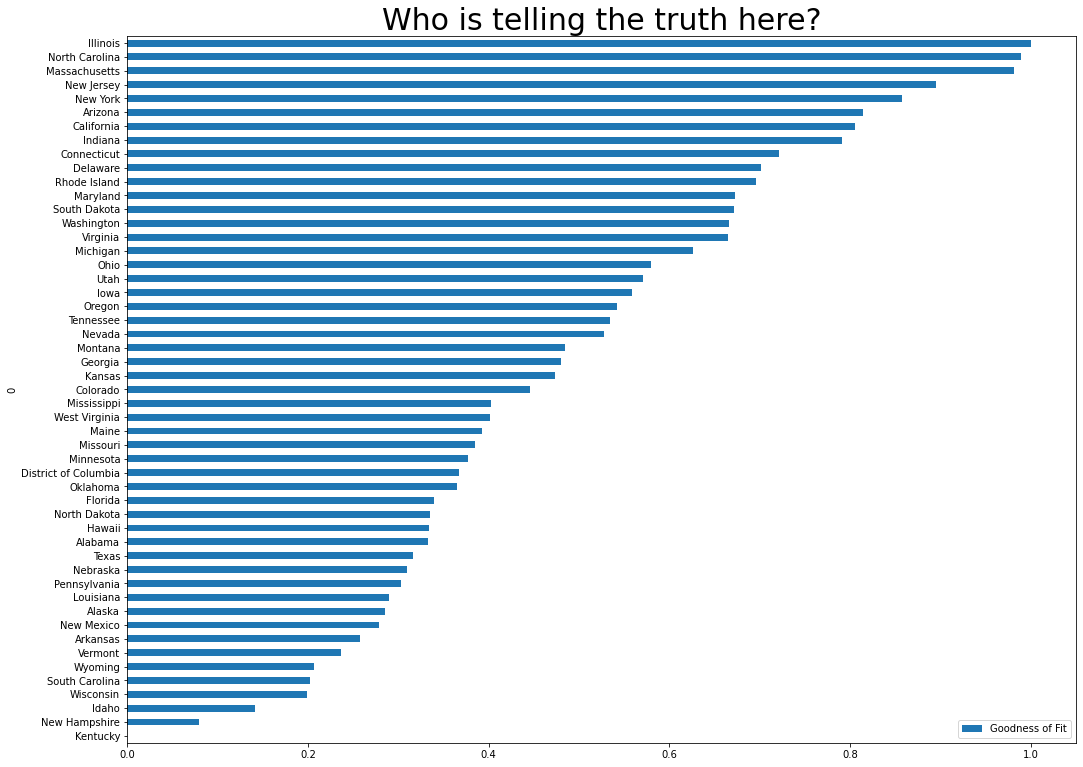

In [298]:
def get_axes(rows, cols):
    fig, axes = plt.subplots(rows, 
                         cols, 
                         figsize=(18, rows*6), 
                         gridspec_kw={'hspace': 0.5, 'wspace': 0.3}, 
                         facecolor='#fbfbfb')
    if (rows * cols) > 1:
        return fig, axes.flatten()
    else:
        return fig, [axes]
    
def getgraphforstate(state, ax):
    txpercents = covidpercents[state]
    txexcess = excessdeaths[state]
    df = [[a[0],a[1]] for a in list(zip(txpercents, txexcess))]
    scaler = MinMaxScaler()
    newframe = pd.DataFrame(scaler.fit_transform(df), columns=['COVID Positive Percent', 'Excess Deaths'], index=txpercents.index)
    plot = newframe.plot.line(ax=ax)
    plot.set_title(state)
    
def drawgraphs(states):
    numrows = math.ceil(len(states) / 3)
    fig, axes = get_axes(numrows, 3);

    for i, state in enumerate(states):
        getgraphforstate(state, axes[i])

def normalize(data):
    return (data - data.min()) * (data.max() - data.min())

def calc_r_squared(pcts, deaths):
    pcts = normalize(pcts)
    deaths = normalize(deaths)
    correlation_matrix = np.corrcoef(pcts, deaths)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2*(correlation_xy/abs(correlation_xy))
    return r_squared

    
states = excessdeaths.columns
results = []
for state in states:
    pcts = covidpercents[state]
    deaths = excessdeaths[state]
    results.append([state, calc_r_squared(pcts, deaths)])

r2results = pd.DataFrame(results).set_index(0).rename(columns={1:"Goodness of Fit"}).sort_values(by=['Goodness of Fit'], ascending=True)
scaler = MinMaxScaler()
r2results['Goodness of Fit'] = [a[0] for a in scaler.fit_transform(r2results)]
plot = r2results.plot.barh(figsize=(17, 13))
plot.set_title('Who is telling the truth here?', size=30)


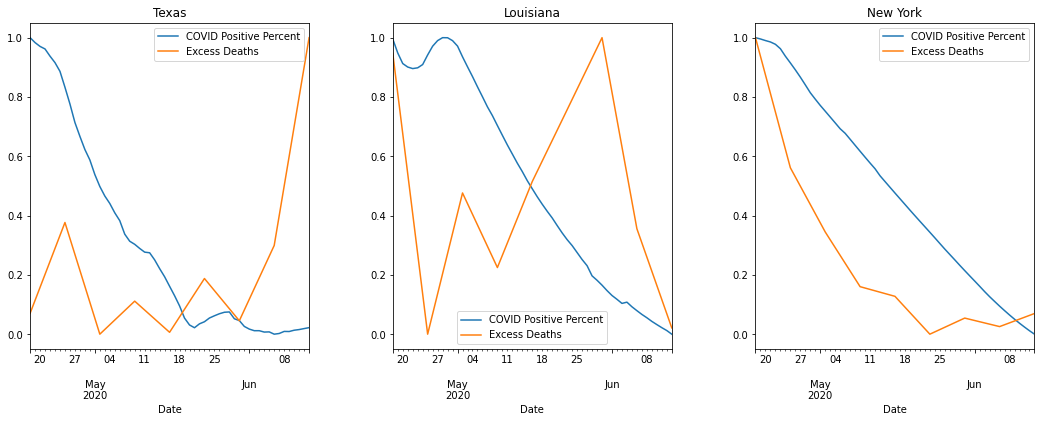

In [299]:
drawgraphs(['Texas', 'Louisiana', 'New York'])

In [300]:
get_excess_deaths()

Jurisdiction,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Week Ending,,,,,,,,,,,,,,,,,,,,,
2020-01-04,-1.018100,-31.623932,3.408374,-2.510004,-3.996221,-3.294893,-7.193959,-9.365559,-23.387097,2.993012,...,-17.211329,-2.179177,-2.884672,-14.492754,-6.810036,-4.108376,-4.313554,-0.561798,-3.510785,90.058480
2020-01-11,-2.558398,38.211382,4.252260,2.396106,-5.006760,1.790451,-7.472613,-0.715564,-15.335463,2.416536,...,17.073171,6.132461,1.866978,25.415282,-14.790997,6.635071,-2.126329,1.193860,-9.080271,-63.483146
2020-01-18,-6.647005,12.244898,8.463252,-1.751714,-0.831940,8.711175,-8.933385,-17.618271,72.413793,0.994369,...,-11.556604,0.264945,-1.954319,10.785953,36.690647,1.978962,-0.175131,11.574847,-0.719091,83.333333
2020-01-25,-3.797468,-23.076923,1.394850,-4.918668,3.361009,9.696547,-5.700077,-5.612245,-10.156250,4.439123,...,-2.360515,1.895323,-2.257946,-5.098039,23.880597,2.391904,-0.159927,0.979192,-1.619819,3.896104
2020-02-01,-7.970514,35.514019,2.326583,2.237654,-0.523330,1.380042,1.138520,-30.769231,8.870968,0.241333,...,13.475177,3.581220,-1.269130,2.596315,-28.571429,3.830645,4.675029,-0.516055,9.732595,-6.474820
2020-02-08,-1.078724,33.620690,0.328947,7.746756,3.932584,5.571327,-7.619048,-20.765027,-6.462585,3.231814,...,-16.313559,1.373995,3.969637,-10.341952,2.605863,10.164885,-0.161962,9.635578,-3.372723,-41.520468
2020-02-15,-2.015288,-5.405405,9.001564,3.660886,-0.192929,-3.832630,-1.945216,-24.217463,-32.330827,0.767524,...,22.747748,-3.773260,5.223506,22.289679,22.137405,0.882029,1.234004,3.978300,7.778343,1.351351
2020-02-22,1.922164,-25.925926,11.979765,5.659684,2.299941,10.103166,2.214314,0.192678,-9.356725,2.016178,...,42.344498,-1.767330,3.083897,-7.716786,-17.602996,3.036475,0.886401,7.920792,26.921961,-45.454545
2020-02-29,9.533948,-16.666667,9.206989,3.100775,-1.184802,11.402851,-3.128761,-6.113537,18.357488,3.268899,...,0.441501,2.438169,2.267632,-0.483481,50.406504,0.315223,0.786855,3.883495,20.903454,32.575758


In [552]:
dailypivot = (
    get_daily_report_data()
    .copy()                         # Copy from the original to save time loading the data.
    .rename(columns={               # Rename the columns to shorter names
        'Date':'date', 
        'Province_State':'state', 
        'Incident_Rate':'rate'
    }) 
    [['state','date','rate']]       # Drop unnecessary columns
    .pivot(                         # Create a pivot table from the data.
        index='date', 
        columns='state', 
        values='rate'
    ) 
    .drop(states_to_drop, axis=1)   # Drop unnecessary locations.
    .diff()                         # Get the date-to-date difference.
    .clip(0, 30)                    # Clip the data at 30 percent. Some data points are too high. 
    .replace(0, np.nan)             # Get rid of pure 0 values. We'll interpolate these.
    .interpolate()                  # Interpolate the newly NAN values.
    .rolling(window=7).mean()       # 7-Day Rolling Average for smoothness.
    .dropna()                       # Drop the first few rows which are a result of the 7-Day rolling average
)

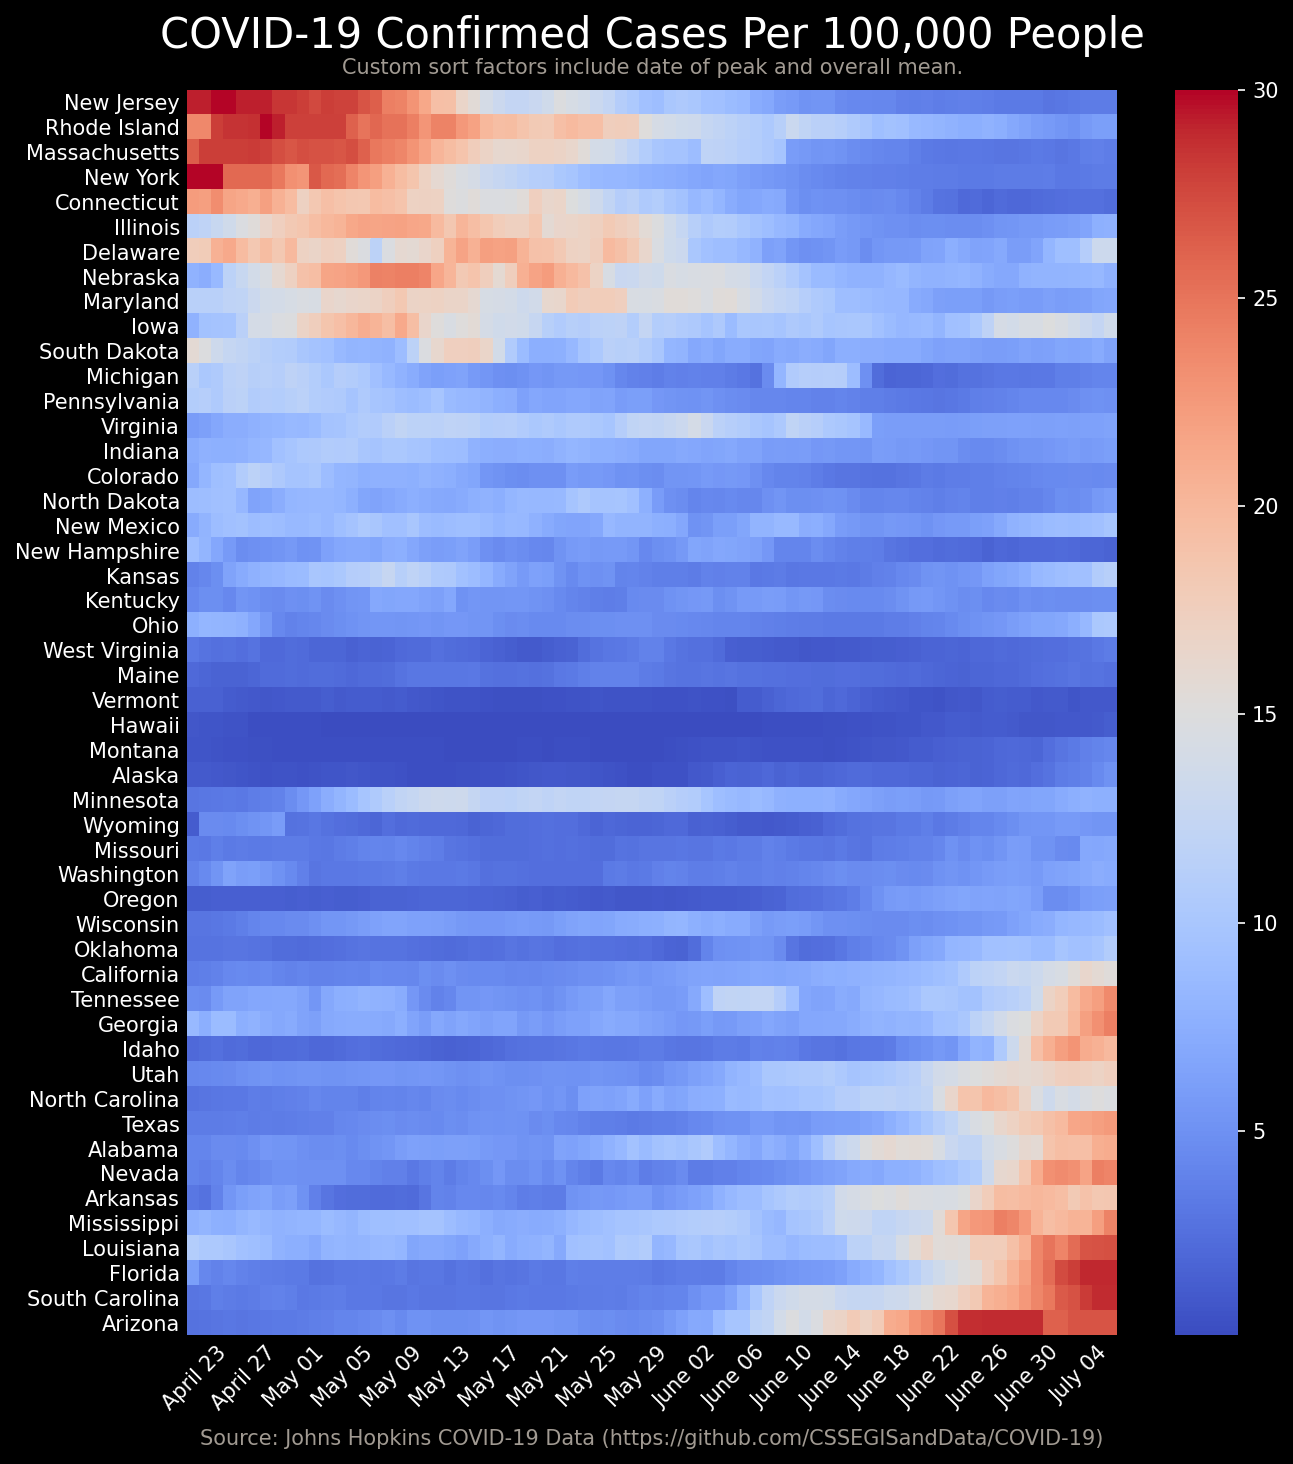

In [574]:
customsort = (dailypivot.apply(lambda x: x * [a*abs(a) for a in range(int(np.ceil(-len(dailypivot.index)/2)),int(np.ceil(len(dailypivot.index)/2)))]).mean() * (dailypivot**3).mean()).sort_values()

with plt.style.context("dark_background"):
    fig, ax = plt.subplots(1, figsize=(10,11), dpi=150)
    idx = [d.strftime("%B %d") for d in dailypivot.index]
    xlabels = [x if i % 4 == 3 else "" for i, x in enumerate(idx)]
    
    ax = sns.heatmap(dailypivot[customsort.index].T, cmap='coolwarm', ax=ax, xticklabels=xlabels)
    ax.set_xticklabels(labels=xlabels, rotation=45, ha="right");
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('COVID-19 Confirmed Cases Per 100,000 People', size=20, pad=20)
    ax.annotate('Source: Johns Hopkins COVID-19 Data (https://github.com/CSSEGISandData/COVID-19)', 
                    (0.5,0), (0, -45), xycoords='axes fraction', color="#a19a92",
                    textcoords='offset points', size=10, va='top', ha="center")
    ax.annotate('Custom sort factors include date of peak and overall mean.', 
                (0.5,1), (0, 15), xycoords='axes fraction', color="#a19a92",
                textcoords='offset points', size=10, va='top', ha="center")
    fig.savefig("covid19-incidence-case.png", dpi=300, bbox_inches="tight", pad_inches=0.5, 
                    facecolor=fig.get_facecolor())



In [545]:
dailypivot = (
    daily_raw
    .copy()                         # Copy from the original to save time loading the data.
    .rename(columns={               # Rename the columns to shorter names
        'Date':'date', 
        'Province_State':'state', 
        'Incident_Rate':'rate'
    }) 
    [['state','date','rate']]       # Drop unnecessary columns
    .pivot(                         # Create a pivot table from the data.
        index='date', 
        columns='state', 
        values='rate'
    ) 
    .drop(states_to_drop, axis=1)   # Drop unnecessary locations.
    .diff()                         # Get the date-to-date difference.
    .clip(0, 30)                    # Clip the data at 30 percent. Some data points are too high. 
    .replace(0, np.nan)             # Get rid of pure 0 values. We'll interpolate these.
    .interpolate()                  # Interpolate the newly NAN values.
    .rolling(window=7).mean()       # 7-Day Rolling Average for smoothness.
    .dropna()                       # Drop the first few rows which are a result of the 7-Day rolling average
)